In [1]:
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from model.neighbors import neighbors

**We cannot publish this data, but we can provide the code and the results.**

In [2]:
ad_data = ad.read_h5ad("../data_private/CD4RNA.h5ad")
sc.pp.log1p(ad_data)
sc.pp.highly_variable_genes(ad_data,n_top_genes=500)
sc.pp.normalize_per_cell(ad_data)
ad_data = ad_data[:,ad_data.var.highly_variable]
sc.pp.pca(ad_data)

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


<Axes: title={'center': 'celltype'}, xlabel='PC1', ylabel='PC2'>

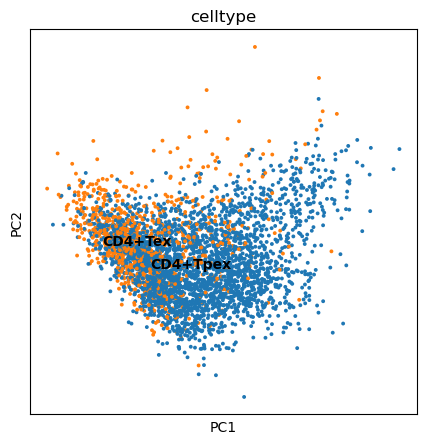

In [3]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.pca(ad_data,color='celltype',legend_loc='on data',ax=ax,show=False)

In [4]:
big_knn_ad = neighbors(ad_data,n_neighbors=30,n_initial_neighbors=30,use_rep='X',copy=True)
small_knn_ad = neighbors(ad_data,n_neighbors=10,n_initial_neighbors=10,use_rep='X',copy=True)
min_trimed_ad = neighbors(ad_data,n_neighbors=10,n_initial_neighbors=30,scheme="min",use_rep="X",copy=True)
max_trimed_ad = neighbors(ad_data,n_neighbors=10,n_initial_neighbors=30,scheme="max",use_rep="X",copy=True)

100%|██████████| 3901/3901 [08:55<00:00,  7.28it/s]


In [5]:
knn_graph = big_knn_ad.obsp['distances']
knn_graph_small = small_knn_ad.obsp['distances']
min_curv_graph = min_trimed_ad.obsp['distances']
max_curv_graph = max_trimed_ad.obsp['distances']
    

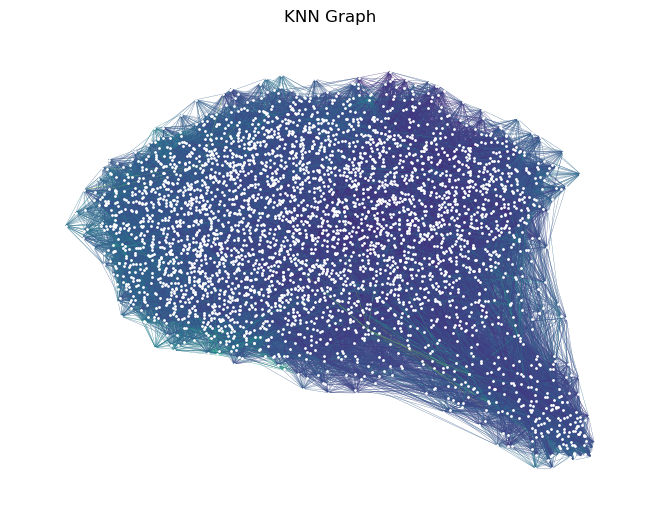

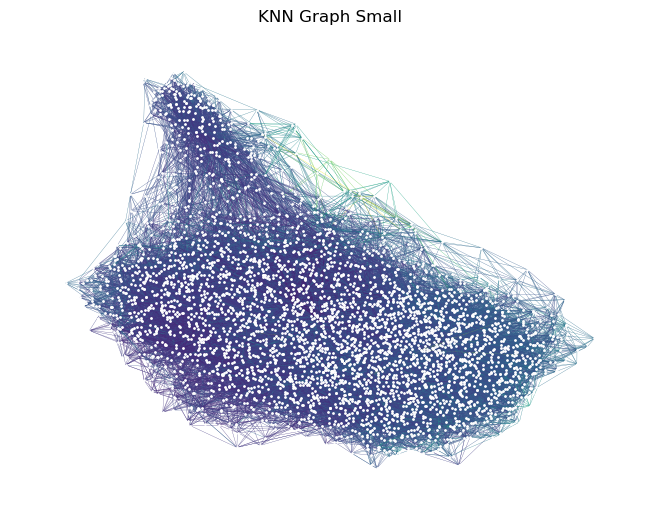

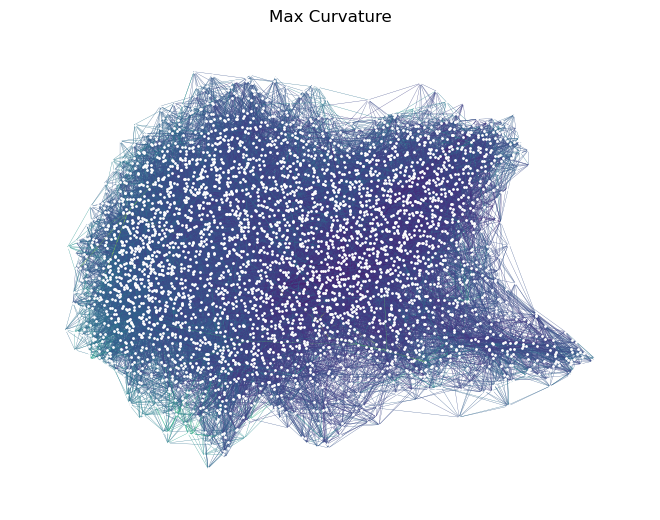

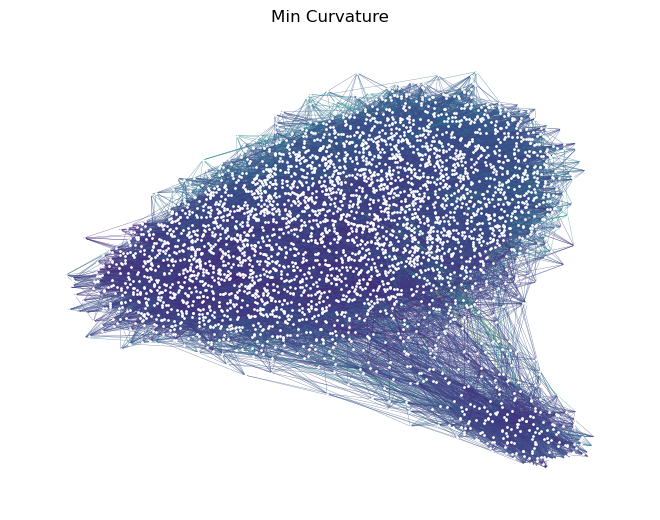

In [6]:
import networkx as nx
def drawGraph(adj):
    graph = nx.from_numpy_array(adj)
    edge_value = nx.get_edge_attributes(graph,'weight')
    edge_value = edge_value.values()
    nx.draw(graph,node_color='white',node_size=1,width=0.2,edge_color=edge_value,edge_cmap=plt.cm.viridis)
    return
for graph,title in zip([knn_graph,knn_graph_small,max_curv_graph,min_curv_graph],["KNN Graph","KNN Graph Small","Max Curvature","Min Curvature"]):
    drawGraph(graph)
    plt.title(title)
    plt.show()

/tmp/ipykernel_166523/462860256.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata=point_ad,resolution=0.5,key_added='clusters')


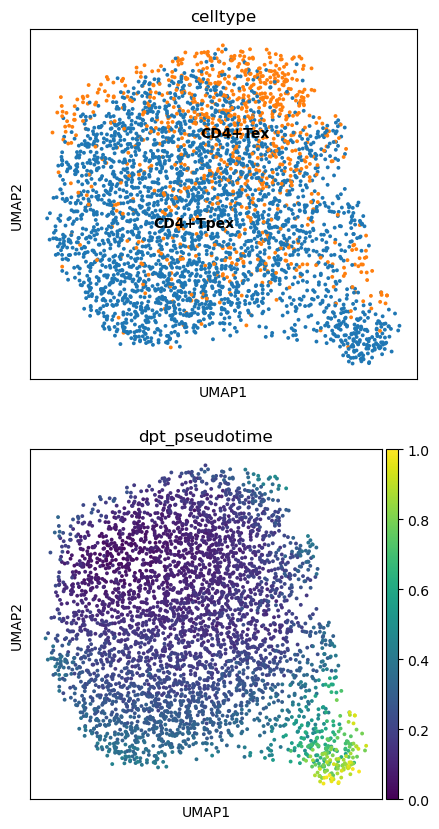

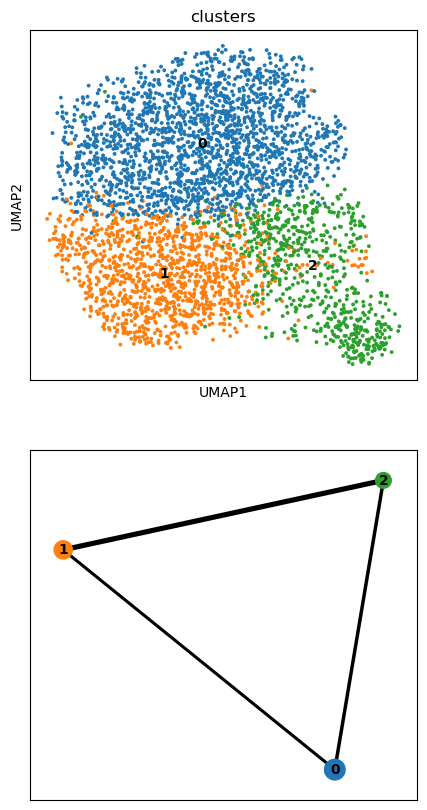

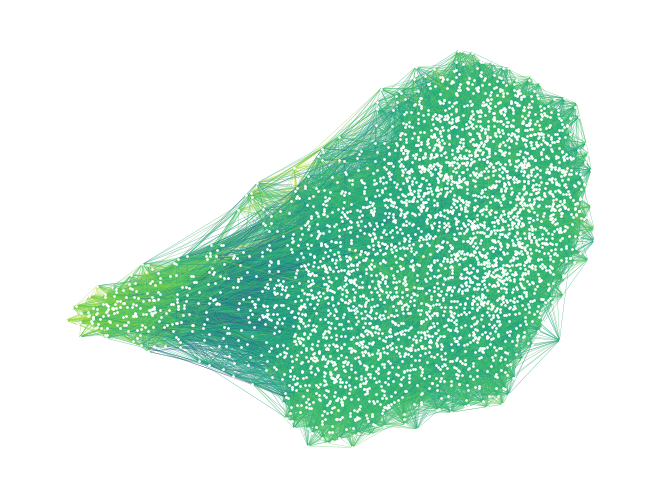

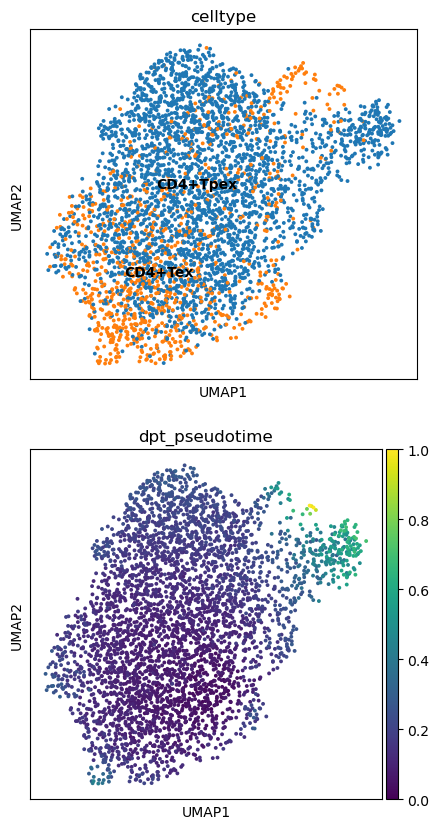

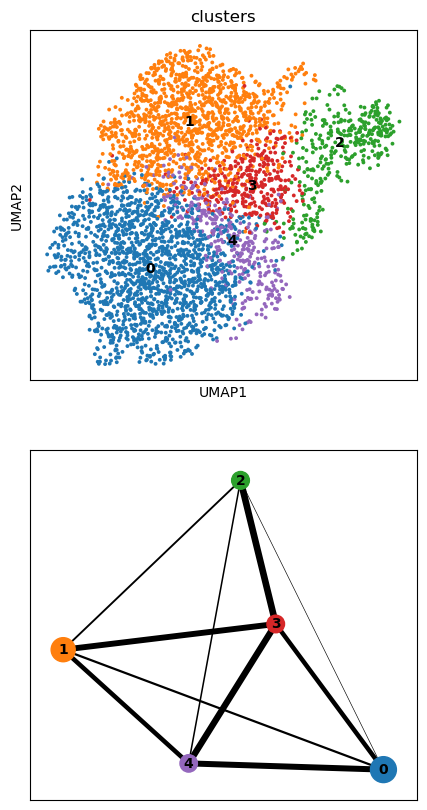

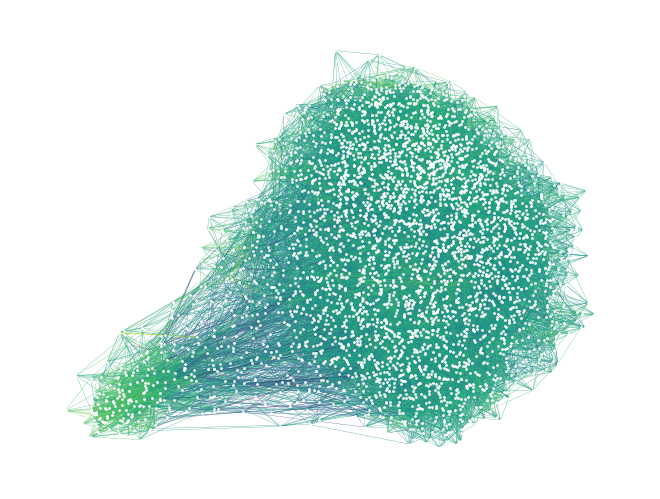

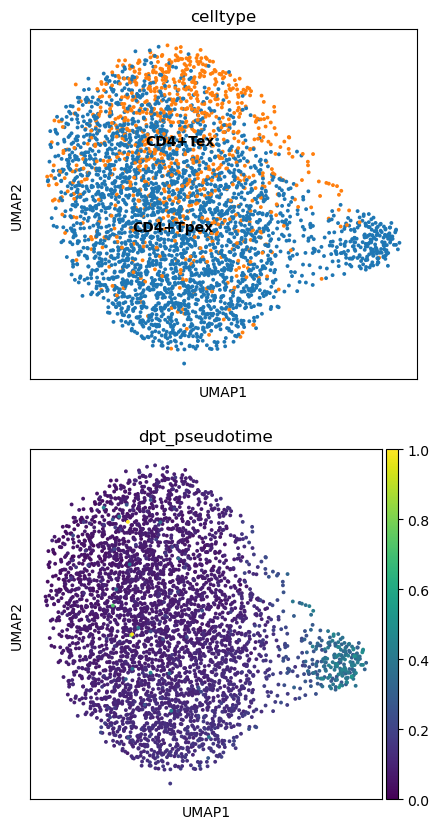

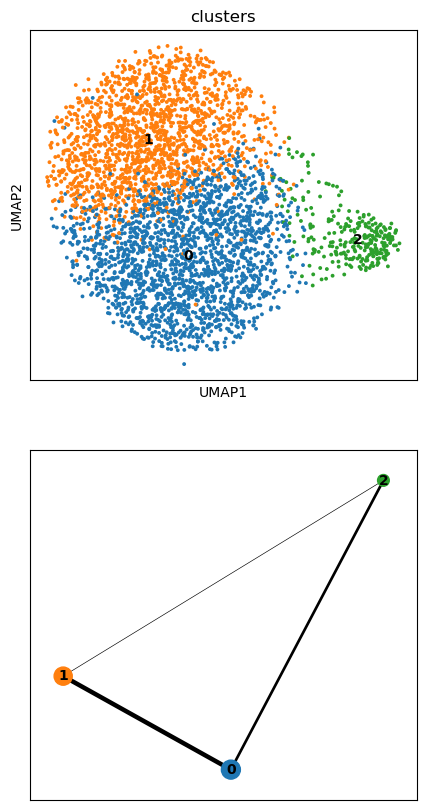

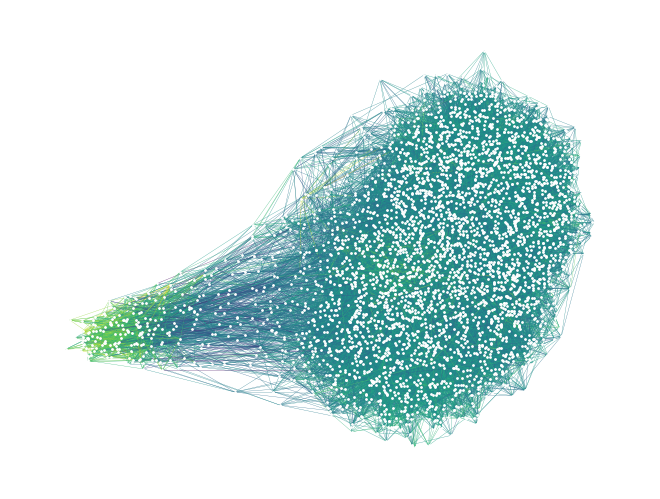

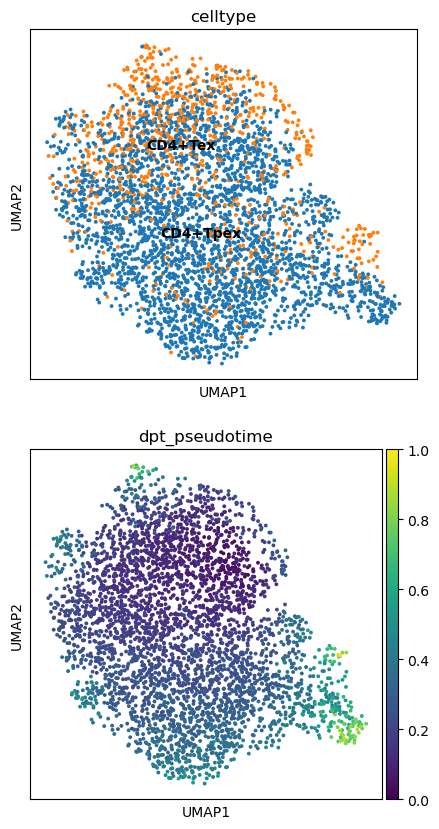

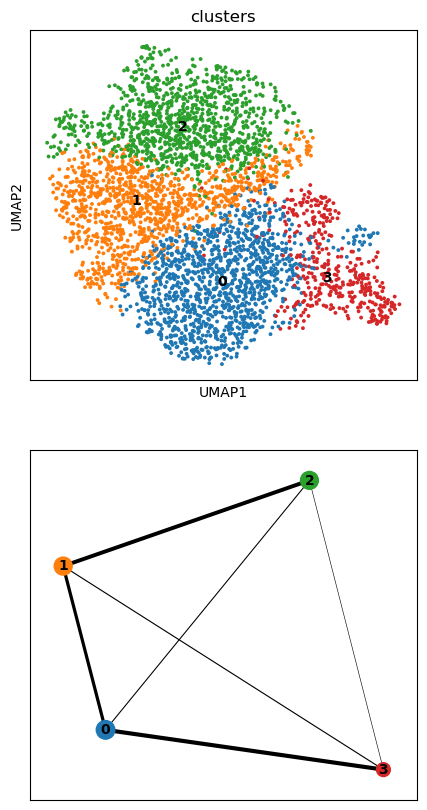

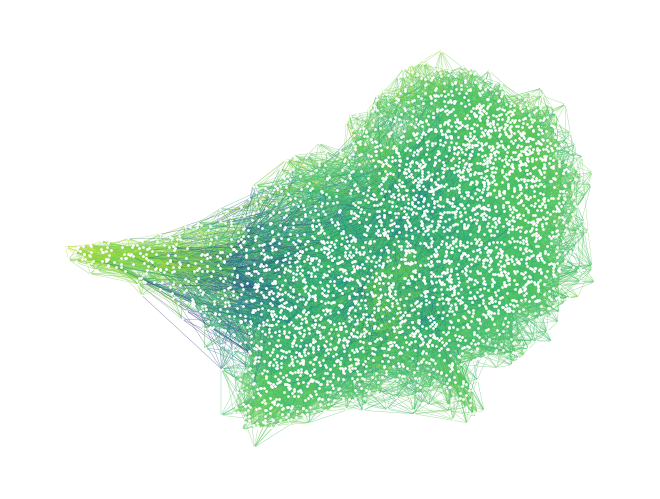

In [7]:
def drawGraph(adj,curvature):
    graph = nx.from_numpy_array(adj)
    curvature_graph = nx.from_numpy_array(curvature)
    edge_value = nx.get_edge_attributes(curvature_graph,'weight')
    edge_value = edge_value.values()
    nx.draw(graph,node_color='white',node_size=1,width=0.2,edge_color=edge_value,edge_cmap=plt.cm.viridis)
    plt.show()
    return
def plotPseudoTime(data):
    point_ad = data.copy()
    sc.tl.draw_graph(point_ad)
    sc.tl.leiden(adata=point_ad,resolution=0.5,key_added='clusters')
    root = np.flatnonzero(point_ad.obs['celltype'] == 'CD4+Tpex')[0]
    point_ad.uns['iroot'] = root
    #sc.pp.neighbors(point_ad,n_neighbors=20)
    sc.tl.umap(point_ad)
    sc.tl.diffmap(point_ad)
    sc.tl.dpt(point_ad)
    fig_1,axs_1 = plt.subplots(2,1,figsize=(5,10))
    fig_2,axs_2 = plt.subplots(2,1,figsize=(5,10))
    sc.pl.umap(point_ad,color=["celltype"],legend_loc="on data",ax=axs_1[0],show=False)
    sc.pl.umap(point_ad,color=["clusters"],legend_loc="on data",ax=axs_2[0],show=False)
    sc.pl.umap(point_ad,color=["dpt_pseudotime"],legend_loc="on data",ax=axs_1[1],show=False)
    sc.tl.paga(point_ad,groups='clusters')
    sc.pl.paga(point_ad,ax=axs_2[1],show=False)
    plt.show()
    return
for ad in [big_knn_ad,small_knn_ad,min_trimed_ad,max_trimed_ad]:
    plotPseudoTime(ad)
    drawGraph(ad.obsp["distances"],ad.obsp["curvature"])

In [ ]:
pass

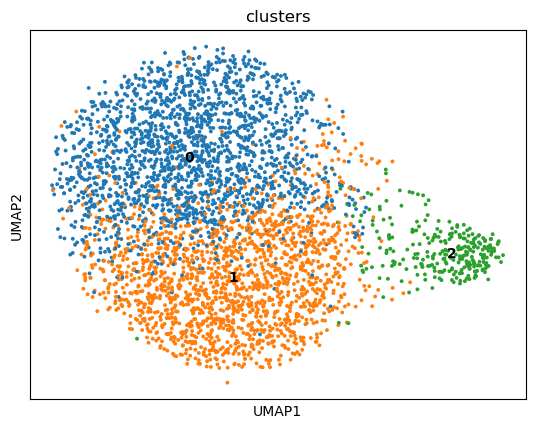

In [10]:
analysis_data = min_trimed_ad.copy()
sc.tl.umap(analysis_data)
sc.tl.louvain(adata=analysis_data,resolution=0.5,key_added='clusters')
sc.pl.umap(analysis_data,color=["clusters"],legend_loc="on data")

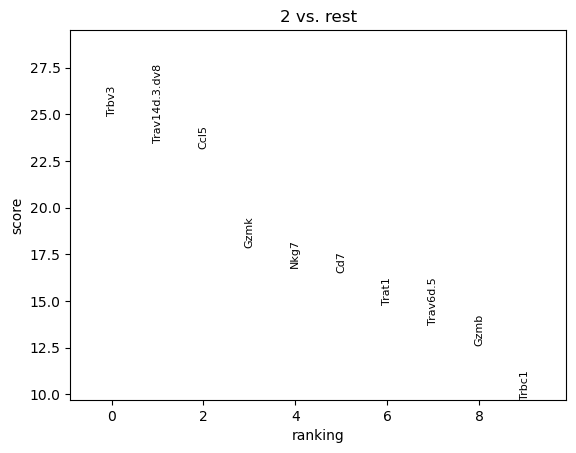

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


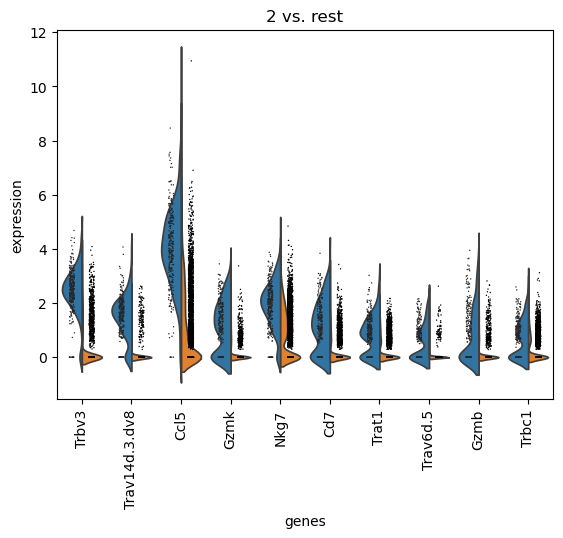

In [19]:
sc.tl.rank_genes_groups(analysis_data,groupby='clusters',method='wilcoxon')
sc.pl.rank_genes_groups(analysis_data,groups=['2'],n_genes=10)
sc.pl.rank_genes_groups_violin(analysis_data,groups=['2'],n_genes=10)

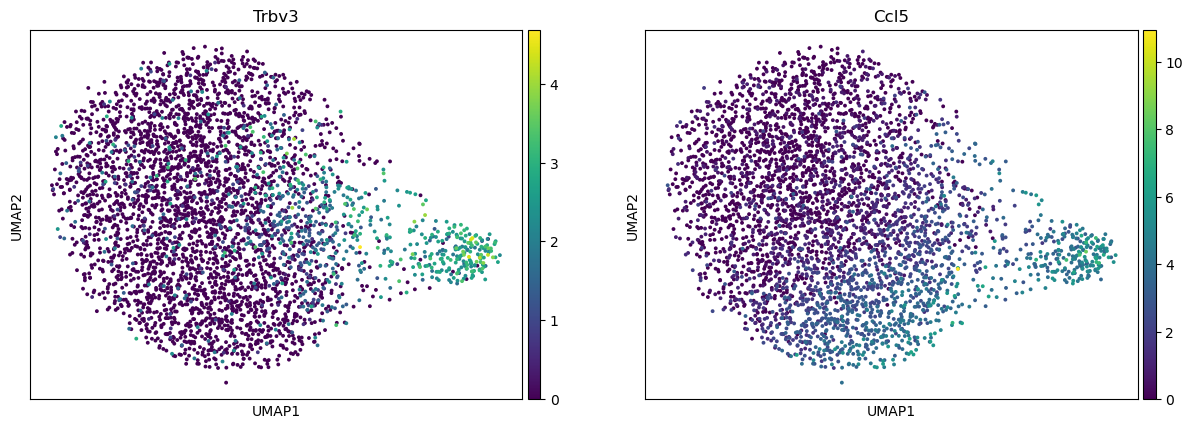

In [22]:
sc.pl.umap(analysis_data,color=['Trbv3','Ccl5'])